In [176]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from pyx.one_hot import one_hot
from tf_coop_model import CountsRegressor, IterablePandasDataset
from tf_coop_model import anscombe_transform, run_one_epoch, spearman_rho, pearson_r
from tf_coop_simulation import background_frequency

In [178]:
train_data_fpath = '../dat/sim/train_labels.csv'
train_raw_simulation_data_fpath = '../dat/sim/train_sequences.simdata'

test_data_fpath = '../dat/sim/test_labels.csv'
test_raw_simulation_data_fpath = '../dat/sim/test_sequences.simdata'

sequences_col = "sequences"
label_cols = ["labels_exp", "labels_out"]

In [179]:
train_df = pd.read_csv(train_data_fpath)
test_df = pd.read_csv(test_data_fpath)
print(len(train_df))

5000


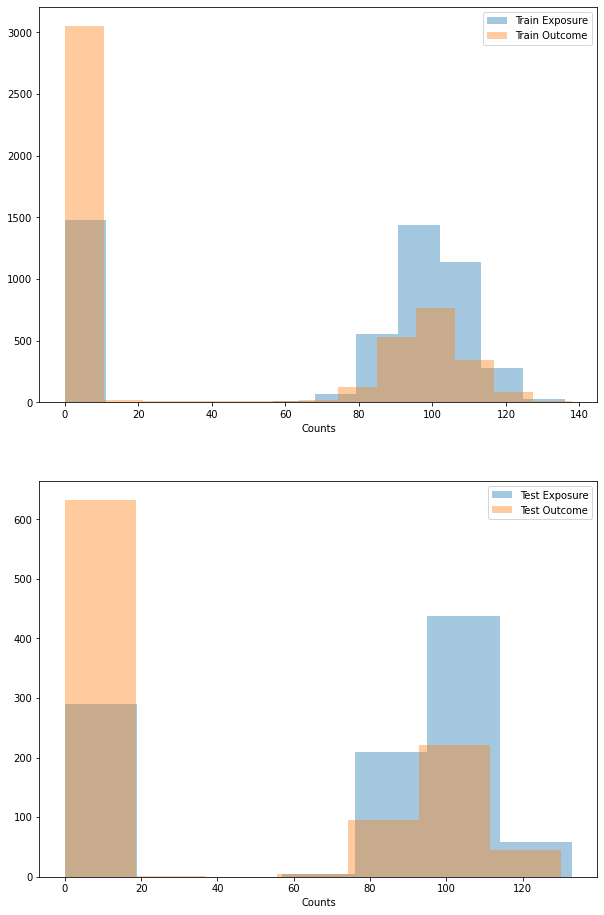

In [180]:
fig, axs = plt.subplots(2, 1, figsize=(10, 16))
sns.distplot(train_df['labels_exp'], kde=False, label="Train Exposure", axlabel="Counts", ax=axs[0])
sns.distplot(train_df['labels_out'], kde=False, label="Train Outcome", axlabel="Counts", ax=axs[0])
sns.distplot(test_df['labels_exp'], kde=False, label="Test Exposure", axlabel="Counts", ax=axs[1])
sns.distplot(test_df['labels_out'], kde=False, label="Test Outcome", axlabel="Counts", ax=axs[1])
axs[0].legend()
axs[1].legend();

In [181]:
train_df['labels_exp_ansc'] = train_df['labels_exp'].map(anscombe_transform)
train_df['labels_out_ansc'] = train_df['labels_out'].map(anscombe_transform)
test_df['labels_exp_ansc'] = test_df['labels_exp'].map(anscombe_transform)
test_df['labels_out_ansc'] = test_df['labels_out'].map(anscombe_transform)

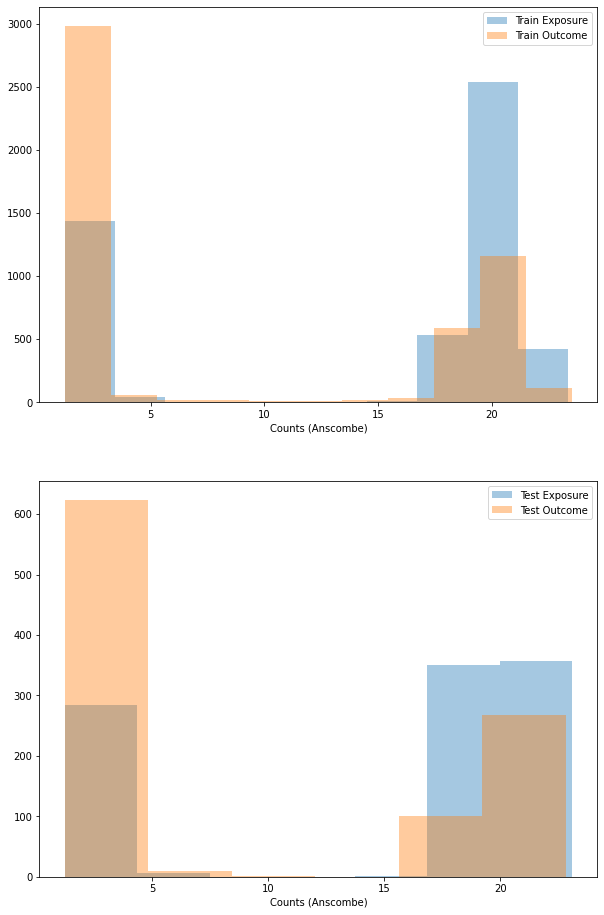

In [182]:
fig, axs = plt.subplots(2, 1, figsize=(10, 16))
sns.distplot(
    train_df['labels_exp_ansc'], kde=False, label="Train Exposure", axlabel="Counts (Anscombe)", ax=axs[0]
)
sns.distplot(train_df['labels_out_ansc'], kde=False, label="Train Outcome", axlabel="Counts (Anscombe)", ax=axs[0])
sns.distplot(test_df['labels_exp_ansc'], kde=False, label="Test Exposure", axlabel="Counts (Anscombe)", ax=axs[1])
sns.distplot(test_df['labels_out_ansc'], kde=False, label="Test Outcome", axlabel="Counts (Anscombe)", ax=axs[1])
axs[0].legend()
axs[1].legend();

In [183]:
def safe_log10(x): return np.log10(1 + x)

train_df['labels_exp_log'] = train_df['labels_exp'].map(safe_log10)
train_df['labels_out_log'] = train_df['labels_out'].map(safe_log10)
test_df['labels_exp_log'] = test_df['labels_exp'].map(safe_log10)
test_df['labels_out_log'] = test_df['labels_out'].map(safe_log10)

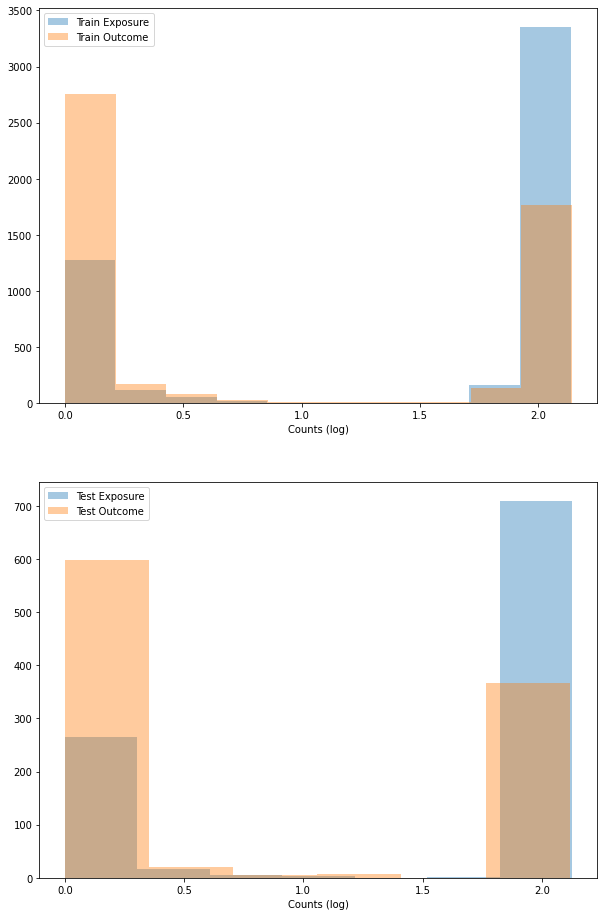

In [184]:
fig, axs = plt.subplots(2, 1, figsize=(10, 16))
sns.distplot(
    train_df['labels_exp_log'], kde=False, label="Train Exposure", axlabel="Counts (log)", ax=axs[0]
)
sns.distplot(train_df['labels_out_log'], kde=False, label="Train Outcome", axlabel="Counts (log)", ax=axs[0])
sns.distplot(test_df['labels_exp_log'], kde=False, label="Test Exposure", axlabel="Counts (log)", ax=axs[1])
sns.distplot(test_df['labels_out_log'], kde=False, label="Test Outcome", axlabel="Counts (log)", ax=axs[1])
axs[0].legend()
axs[1].legend();

In [185]:
train_df = pd.read_csv(train_data_fpath)
train_dataset = IterablePandasDataset(
    train_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
)
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=512, num_workers=0
)

In [186]:
original_simulation_df = pd.read_csv(train_raw_simulation_data_fpath, sep="\t")

In [187]:
merged_data_df = original_simulation_df.merge(train_df, left_on="sequence", right_on="sequences")
merged_data_df

,seqName,sequence,embeddings,has_exposure,has_outcome,has_both,sequences,labels_exp,labels_out
0,train-synth0,CGACAAACCGCGATAGCGAATTCGTTAAATACTGGCGTATTTCTAC...,pos-60_TAL1_known1-TCTAACAGATGTCGGT,0,1,0,CGACAAACCGCGATAGCGAATTCGTTAAATACTGGCGTATTTCTAC...,0,0
1,train-synth1,AAAAATGGTACGTGATATCTTGAAAAAAGGAATGAATAGTTACGTA...,pos-49_GATA_disc1-CATGATTAGC,1,0,0,AAAAATGGTACGTGATATCTTGAAAAAAGGAATGAATAGTTACGTA...,96,0
2,train-synth2,TCCGAGCTCTGATGACGTATCTGTGGCGTTTGTCGCCCCCGCTGAC...,pos-65_TAL1_known1-GACGCCAGATGTTCGA,0,1,0,TCCGAGCTCTGATGACGTATCTGTGGCGTTTGTCGCCCCCGCTGAC...,0,0
3,train-synth3,TAAGCTCTTTGCGATAAGACAATACTGGACGTAAATCAGATCAGTC...,"pos-9_GATA_disc1-TGCGATAAGA,pos-65_TAL1_known1...",1,1,1,TAAGCTCTTTGCGATAAGACAATACTGGACGTAAATCAGATCAGTC...,93,99
4,train-synth4,TGGCAGAGATAAGGTTTTAAACAGCTAGAGCAAGCGAGTTGTTGAA...,"pos-4_GATA_disc1-AGAGATAAGG,pos-79_TAL1_known1...",1,1,1,TGGCAGAGATAAGGTTTTAAACAGCTAGAGCAAGCGAGTTGTTGAA...,104,111
...,...,...,...,...,...,...,...,...,...
4995,train-synth4995,TTTTAACGTCGCTGTACCGATGGCAACAGATAAGCTCTTATTTAAG...,"pos-25_GATA_disc1-ACAGATAAGC,pos-54_TAL1_known...",1,1,1,TTTTAACGTCGCTGTACCGATGGCAACAGATAAGCTCTTATTTAAG...,104,100
4996,train-synth4996,GATAAGCGCTGATAAGCACCTTGAGCACACTTCAGAAACTGATCAG...,"pos-7_GATA_disc1-GCTGATAAGC,pos-84_TAL1_known1...",1,1,1,GATAAGCGCTGATAAGCACCTTGAGCACACTTCAGAAACTGATCAG...,101,97
4997,train-synth4997,AAACGATAAGGTATGAGCGTGTTTCTGTTTGTACAAAGGCGACAGC...,"pos-1_GATA_disc1-AACGATAAGG,pos-84_TAL1_known1...",1,1,1,AAACGATAAGGTATGAGCGTGTTTCTGTTTGTACAAAGGCGACAGC...,109,113
4998,train-synth4998,AAACGCAAAGTCAGATAAGGTCTGCCGGAACGTCTTAATTACGCAC...,pos-10_GATA_disc1-TCAGATAAGG,1,0,0,AAACGCAAAGTCAGATAAGGTCTGCCGGAACGTCTTAATTACGCAC...,93,0


In [198]:
both_motifs_df = merged_data_df[(merged_data_df['has_both'] == 1)]
exposure_motif_df = merged_data_df[(merged_data_df['has_exposure'] == 1) & (~merged_data_df['has_both'])]
outcome_motif_df = merged_data_df[(merged_data_df['has_outcome'] == 1) & (~merged_data_df['has_both'])]
neither_motif_df = merged_data_df[
    (merged_data_df['has_exposure'] == 0) & (merged_data_df['has_outcome'] == 0)
]

/home/stephenmalina/anaconda3/envs/deepmr/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


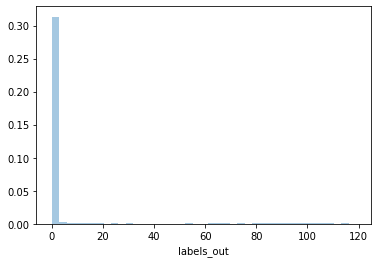

In [199]:
sns.distplot(exposure_motif_df.labels_out)

/home/stephenmalina/anaconda3/envs/deepmr/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


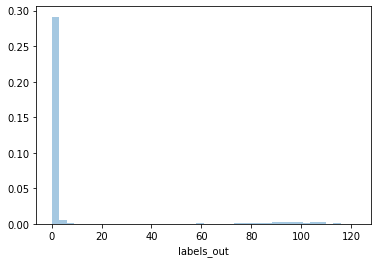

In [200]:
sns.distplot(outcome_motif_df.labels_out)

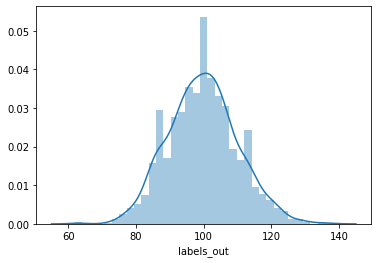

In [201]:
sns.distplot(both_motifs_df.labels_out)